In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from random import randint, seed
from IPython.display import display
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.neighbors import KNeighborsClassifier



# Import du dataset

In [3]:
path = 'maladie_cardiaque.csv'
maladie = pd.read_csv(path,sep=',',header=0, index_col=1)
maladie = maladie.drop(columns=['Unnamed: 0'])
maladie.head(5)
 

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade
id,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non


# Analyse superficielle du dataset

In [30]:
from data_analyzer import analyse

resultat = analyse(maladie)
display(resultat)

(68969, 18)

,Name,dtypes,Missing,Miss_Percent,Unique,First Value,Second Value,Third Value
0,age,int64,0,0.0,8066,18393,20228,18857
1,genre,object,0,0.0,2,homme,femme,femme
2,taille,float64,0,0.0,103,168.0,156.0,165.0
3,Poids,float64,0,0.0,281,62.0,85.0,64.0
4,pression_systo,float64,0,0.0,119,110.0,140.0,130.0
5,pression_diasto,float64,0,0.0,94,80.0,90.0,70.0
6,cholesterol,object,0,0.0,3,normal,tres eleve,tres eleve
7,glycemie,int64,0,0.0,3,1,1,1
8,fumeur,object,0,0.0,2,non fumeur,non fumeur,non fumeur
9,conso_alco,object,0,0.0,2,non,non,non


In [12]:
maladie.describe()

,age,taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,1.226457,0.803729
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.572270,0.397179
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,1.000000


# Data Prep

Création d'une colonne pour avoir l'âge en année

In [13]:
maladie["Age (années)"] = maladie["age"]/365

Ajout d'une colonne avec l'IMC des individus

In [14]:
maladie["IMC"] = maladie['Poids']/((maladie['taille']/100)*(maladie['taille']/100))
maladie

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age (années),IMC
id,,,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,50.391781,21.967120
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,55.419178,34.927679
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,51.663014,23.507805
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,48.282192,28.710479
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,47.873973,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,homme,168,76.0,120,80,normal,1,fumeur,non,1,non,52.712329,26.927438
99995,22601,femme,158,126.0,140,90,eleve,2,non fumeur,non,1,oui,61.920548,50.472681
99996,19066,homme,183,105.0,180,90,tres eleve,1,non fumeur,oui,0,oui,52.235616,31.353579


Binarisation des données

In [31]:
maladie['genre_binaire'] = maladie['genre'].map({'homme': 0, 'femme': 1})
maladie['conso_alco_binaire'] = maladie['conso_alco'].map({'non': 0, 'oui': 1})
maladie['fumeur_binaire'] = maladie['fumeur'].map({'non fumeur': 0, 'fumeur': 1})
maladie['malade_binaire'] = maladie['malade'].map({'non': 0, 'oui': 1})

Caractérisation de l'IMC

In [15]:
maladie.drop_duplicates(inplace=True)
labels = ['Sous-poids', 'Normal', 'Surpoids', 'Obèse']
maladie['IMC_Categorie'] = pd.cut(maladie['IMC'], bins=[0, 18.5, 25, 30, float('inf')], labels=labels, include_lowest=True)


Séparation des individus en tranche d'âge

In [16]:
bins = [0, 18, 35, 50, 70, float('inf')]
labels = ['0-18', '19-35', '36-50', '51-70', '70+']
maladie['Age_Categorie'] = pd.cut(maladie['Age (années)'], bins=bins, labels=labels, include_lowest=True)

In [17]:
maladie['Ratio_Poids_Taille'] = maladie['Poids'] / (maladie['taille'] / 100)

In [18]:
conditions = [
    (maladie['pression_systo'] < 120) & (maladie['pression_diasto'] < 80),
    (maladie['pression_systo'] >= 120) & (maladie['pression_systo'] < 130) & (maladie['pression_diasto'] < 80),
    (maladie['pression_systo'] >= 130) | (maladie['pression_diasto'] >= 80)
]
labels = ['Normale', 'Hypertension Légère', 'Hypertension']
maladie['Pression_Arterielle_Categorie'] = np.select(conditions, labels, default='Inconnu')

In [32]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age (années),IMC,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire
id,,,,,,,,,,,,,,,,,,,,,,
0,18393,homme,168.0,62.0,110.0,80.0,normal,1,non fumeur,non,1,non,50.391781,21.967120,Normal,51-70,36.904762,Hypertension,0,0,0,0
1,20228,femme,156.0,85.0,140.0,90.0,tres eleve,1,non fumeur,non,1,oui,55.419178,34.927679,Obèse,51-70,54.487179,Hypertension,1,0,0,1
2,18857,femme,165.0,64.0,130.0,70.0,tres eleve,1,non fumeur,non,0,oui,51.663014,23.507805,Normal,51-70,38.787879,Hypertension,1,0,0,1
3,17623,homme,169.0,82.0,150.0,100.0,normal,1,non fumeur,non,1,oui,48.282192,28.710479,Surpoids,36-50,48.520710,Hypertension,0,0,0,1
4,17474,femme,156.0,56.0,100.0,60.0,normal,1,non fumeur,non,0,non,47.873973,23.011177,Normal,36-50,35.897436,Normale,1,0,0,0


Détéctions des outliners

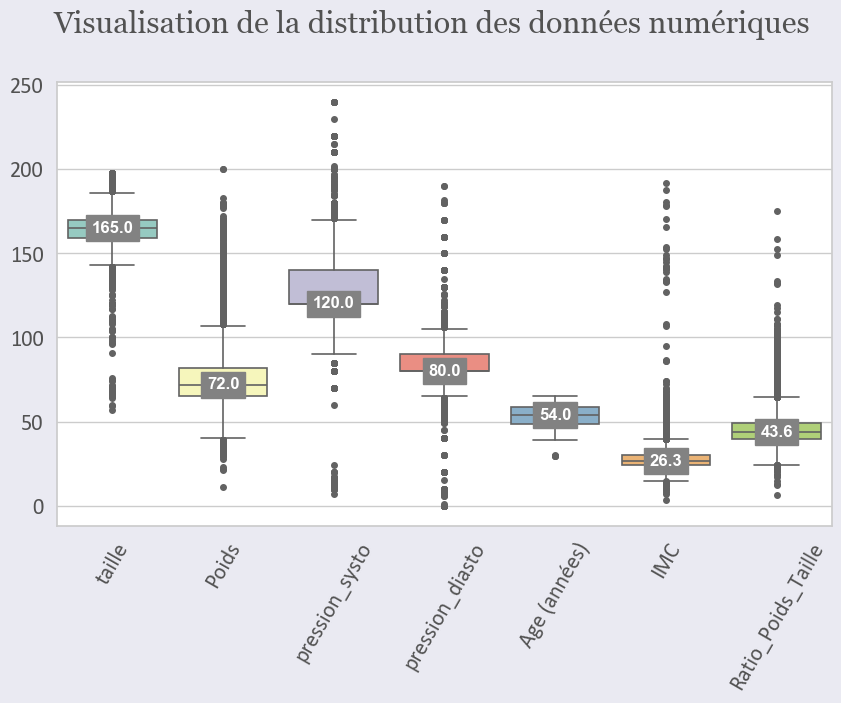

In [33]:
# Boxplot des outliners

var_num = ['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age (années)", 'IMC', "Ratio_Poids_Taille"]
maladie[var_num] = maladie[var_num].apply(pd.to_numeric, errors='coerce', axis=1)

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

x = sns.boxplot(data=maladie,
                       palette='Set3',
                       linewidth=1.2,
                       fliersize=2,
                       order=['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age (années)",'IMC', "Ratio_Poids_Taille"],
                       flierprops=dict(marker='o', markersize=4))

font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

title = 'Visualisation de la distribution des données numériques'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)

for i, box in enumerate(ax.artists):
         col = box.get_facecolor()
         plt.setp(ax.lines[i*6+5], mfc=col, mec=col)

lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    ax.text(
        cat,
        y,
        f'{y}',
        ha='center',
        va='center',
        fontweight='semibold',
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.show()

In [21]:
maladie["IMC"].mean()

27.557610036546496

Suppression des outliners

In [22]:
out_filter = ((maladie["pression_systo"]>250) | (maladie["pression_diasto"]>200))
maladie = maladie[~out_filter]
out_filter2 = ((maladie["pression_systo"] < 0) | (maladie["pression_diasto"] < 0))
maladie = maladie[~out_filter2]
out_filter3 = ((maladie["taille"] > 200))
maladie = maladie[~out_filter3]
out_filter4 = ((maladie["IMC"] > 200))
maladie = maladie[~out_filter4]

In [15]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age (années),IMC,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,
0,18393,homme,168.0,62.0,110.0,80.0,normal,1,non fumeur,non,1,non,50.391781,21.967120,Normal,51-70,36.904762,Hypertension
1,20228,femme,156.0,85.0,140.0,90.0,tres eleve,1,non fumeur,non,1,oui,55.419178,34.927679,Obèse,51-70,54.487179,Hypertension
2,18857,femme,165.0,64.0,130.0,70.0,tres eleve,1,non fumeur,non,0,oui,51.663014,23.507805,Normal,51-70,38.787879,Hypertension
3,17623,homme,169.0,82.0,150.0,100.0,normal,1,non fumeur,non,1,oui,48.282192,28.710479,Surpoids,36-50,48.520710,Hypertension
4,17474,femme,156.0,56.0,100.0,60.0,normal,1,non fumeur,non,0,non,47.873973,23.011177,Normal,36-50,35.897436,Normale


# DataViz

Distribution de l'âge

c:\Users\ELE623c5ce409945\OneDrive - LECNAM\2eme annee\4eme semestre\Projet - MaladieCardioVasculaire\heart_attack\vm\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


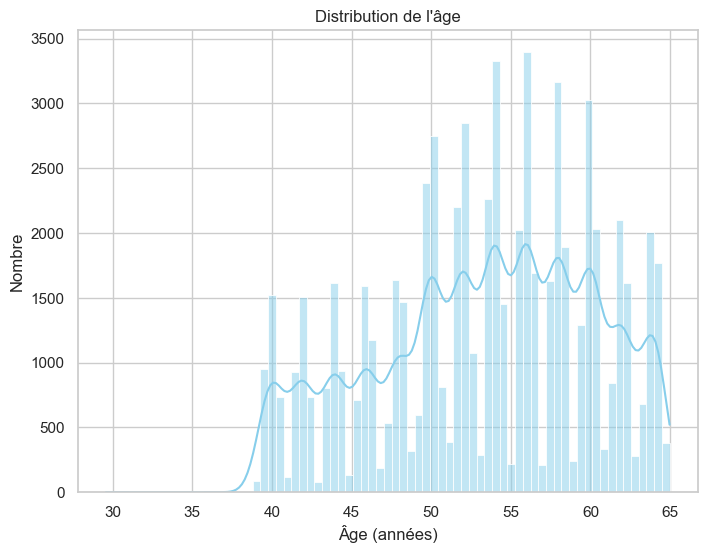

In [24]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot avec seaborn
ax = plt.subplot(111)  # Utilisation d'un seul subplot pour ce tracé
sns.histplot(maladie['Age (années)'], ax=ax, kde=True, color='skyblue')  # Ajout d'un kernel density estimate (KDE) pour une meilleure visualisation de la distribution
plt.title("Distribution de l'âge")  # Ajout d'un titre descriptif

# Ajout de labels pour les axes
plt.xlabel("Âge (années)")
plt.ylabel("Nombre")

# Ajout de la grille pour une meilleure lisibilité
plt.grid(True)

plt.show()

Répartition par genre

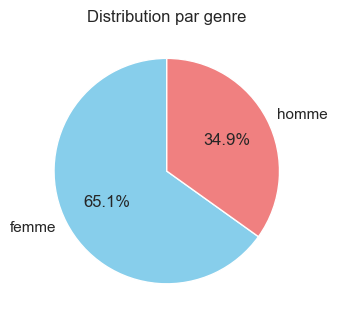

In [25]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot
plt.subplot(121)  # Utilisation d'un seul subplot pour ce tracé
plt.title("Distribution par genre")  # Ajout d'un titre descriptif

# Création du diagramme circulaire avec des couleurs personnalisées
colors = ['skyblue', 'lightcoral', 'lightgreen']
plt.pie(maladie['genre'].value_counts(), labels=maladie['genre'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)

plt.show()


In [26]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age (années),IMC,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,
0,18393,homme,168.0,62.0,110.0,80.0,normal,1,non fumeur,non,1,non,50.391781,21.967120,Normal,51-70,36.904762,Hypertension
1,20228,femme,156.0,85.0,140.0,90.0,tres eleve,1,non fumeur,non,1,oui,55.419178,34.927679,Obèse,51-70,54.487179,Hypertension
2,18857,femme,165.0,64.0,130.0,70.0,tres eleve,1,non fumeur,non,0,oui,51.663014,23.507805,Normal,51-70,38.787879,Hypertension
3,17623,homme,169.0,82.0,150.0,100.0,normal,1,non fumeur,non,1,oui,48.282192,28.710479,Surpoids,36-50,48.520710,Hypertension
4,17474,femme,156.0,56.0,100.0,60.0,normal,1,non fumeur,non,0,non,47.873973,23.011177,Normal,36-50,35.897436,Normale


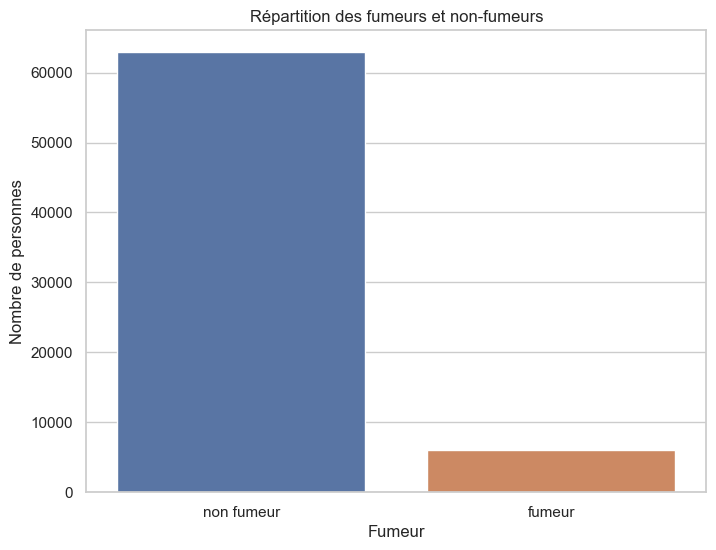

In [27]:
# Diagramme en barres de fumeurs et non-fumeurs
plt.figure(figsize=(8, 6))
sns.countplot(x='fumeur', data=maladie)
plt.title('Répartition des fumeurs et non-fumeurs')
plt.xlabel('Fumeur')
plt.ylabel('Nombre de personnes')
plt.show()

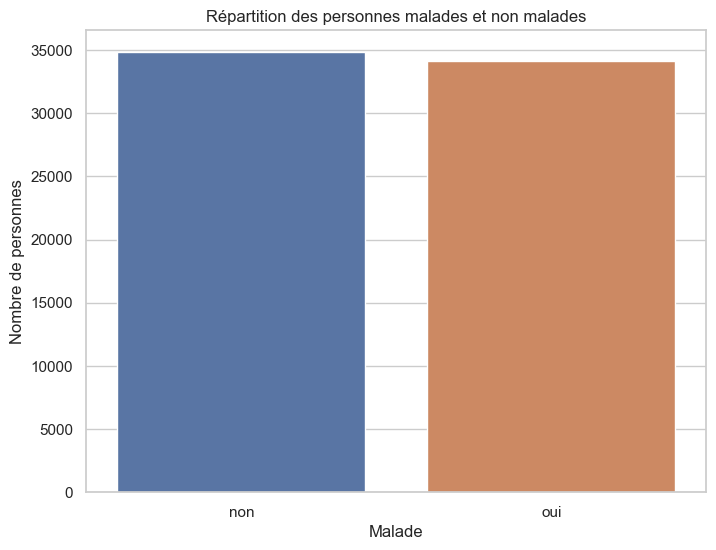

In [28]:
# Diagramme en barres de la présence de maladies
plt.figure(figsize=(8, 6))
sns.countplot(x='malade', data=maladie)
plt.title('Répartition des personnes malades et non malades')
plt.xlabel('Malade')
plt.ylabel('Nombre de personnes')
plt.show()

# Modèle IA

KNN

In [ ]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,IMC,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire,IMC_Categorie,Age_Categorie
id,,,,,,,,,,,,,,,,,,,
0,50.0,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,21.967120,0,0,0,0,Normal,36-50
1,55.0,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,34.927679,1,0,0,1,Obèse,51-70
2,52.0,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,23.507805,1,0,0,1,Normal,51-70
3,48.0,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,28.710479,0,0,0,1,Surpoids,36-50
4,48.0,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,23.011177,1,0,0,0,Normal,36-50


In [ ]:
data_col = maladie[['age','taille','Poids','pression_systo','pression_diasto','glycemie','activite_physique','IMC','fumeur_binaire','conso_alco_binaire','malade_binaire','genre_binaire']]
data_col.head()

,age,taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique,IMC,fumeur_binaire,conso_alco_binaire,malade_binaire,genre_binaire
id,,,,,,,,,,,,
0,50.0,168,62.0,110,80,1,1,21.967120,0,0,0,0
1,55.0,156,85.0,140,90,1,1,34.927679,0,0,1,1
2,52.0,165,64.0,130,70,1,0,23.507805,0,0,1,1
3,48.0,169,82.0,150,100,1,1,28.710479,0,0,1,0
4,48.0,156,56.0,100,60,1,0,23.011177,0,0,0,1


In [ ]:
x = data_col.iloc[:, :-2]
y = data_col.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.2)

In [ ]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [ ]:
import math
math.sqrt(len(y_test))

115.05216208311776

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 115, p = 2, metric = 'euclidean')
classifier.fit(x_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=115)

In [ ]:
y_pred = classifier.predict(x_test)
y_pred

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[2957 1878]
 [ 898 7504]]


In [ ]:
print(accuracy_score(y_test,y_pred))

0.7902848077358918
